# 3 Model Training and Prediction

This notebook trains and evaluates a predictive model using the imputed feature matrix with depth-2 interaction terms. It includes model selection, training, prediction, evaluation, and export of results.

## Contents

- **3.1 Load Transformed Dataset**
- **3.2 Define Target and Features**
- **3.3 Train-Test Split**
- **3.4 Model Training**
- **3.5 Prediction and Evaluation**
- **3.6 Export Predictions**
- **3.7 Save Model Artifact**

Load essential packages for data access, manipulation, and file handling.

In [1]:
# Import required libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

## 3.1 Load Transformed Dataset

Load the imputed feature matrix with depth-2 interactions from the export stage.

In [2]:
# Load Transformed Dataset
imputed_df = pd.read_csv('../data/interaction/earthquake_imputed_2way.csv')
features_imputed = ['dmin', 'Year', 'cdi', 'dmin:Year', 'gap', 'sig', 'magnitude', 'depth']
raw_df = pd.read_csv('../data/interaction/earthquake_raw_2way.csv')
features_raw = ['Year', 'nst', 'sig', 'magnitude', 'Year:magnitude', 'depth']


## 3.2 Define Target and Features

Specify the target variable for prediction and construct the feature matrix. This step isolates the outcome column (`tsunami`) from the rest of the dataset, preparing inputs for model training.

- Target variable: `tsunami` (binary classification)
- Feature matrix: all other columns from the transformed dataset
- No feature pruning or filtering is applied at this stage
- Class distribution is printed for diagnostic clarity

In [3]:
# Define target column
target = 'tsunami'  # Replace with actual target if different

## 3.3 Train-Test Split

Split the dataset into training and test sets using stratified sampling to preserve class balance. This ensures that the model is trained and evaluated on representative distributions of the target variable.

- Split ratio: 80% train / 20% test
- Stratification: enabled to preserve class proportions
- Random seed: 42 for reproducibility

In [4]:
# Stratified split to preserve class distribution
def split_data(df: pd.DataFrame, target_col: str = "target", test_size: float = 0.2, random_state: int = 42):
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    return train_test_split(X, y, test_size=test_size, random_state=random_state, stratify=y)

X_train_imputed, X_test_imputed, y_train_imputed, y_test_imputed = split_data(imputed_df, target)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = split_data(raw_df, target)

# Confirm shapes
print("X_train:", X_train_imputed.shape)
print("X_test:", X_test_imputed.shape)
print("y_train:", y_train_imputed.shape)
print("y_test:", y_test_imputed.shape)

X_train: (625, 15)
X_test: (157, 15)
y_train: (625,)
y_test: (157,)


## 3.4 Model Training

Train a tree-based classifier using the training set. Random Forest is selected for its robustness and invariance to feature scaling. Class imbalance is addressed using `class_weight='balanced'`.

- Model: `RandomForestClassifier`
- Parameters: 100 trees, max depth 8, balanced class weights
- Input: imputed feature matrix (`X_train_imputed`, `y_train_imputed`)
- Optional: raw matrix training for comparison

In [5]:
# Initialize model
model_imputed = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# Fit model on imputed feature matrix
model_imputed.fit(X_train_imputed, y_train_imputed)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)

In [6]:
model_raw = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# Fit model on imputed feature matrix
model_raw.fit(X_train_raw, y_train_raw)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)

## 3.5 Prediction and Evaluation

Generate predictions on the test set and evaluate model performance using standard classification metrics.

- Predictions: binary labels and class probabilities
- Metrics: confusion matrix, classification report, ROC AUC
- Input: `X_test_imputed`, `y_test_imputed`
- Optional: evaluation on raw matrix for comparison

In [7]:
# Predict labels and probabilities
y_pred = model_imputed.predict(X_test_imputed)
y_proba = model_imputed.predict_proba(X_test_imputed)[:, 1]

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba))

Confusion Matrix:
 [[87  9]
 [ 1 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.91      0.95        96
           1       0.87      0.98      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157


ROC AUC Score: 0.9617486338797815


In [8]:
# Predict labels and probabilities
y_pred_raw = model_raw.predict(X_test_raw)
y_proba_raw = model_raw.predict_proba(X_test_raw)[:, 1]
# Evaluation metrics
print("Raw ROC AUC:", roc_auc_score(y_test_raw, y_proba_raw))

Raw ROC AUC: 0.9588456284153005


## 3.6 Apply Selected Features

Apply the previously selected feature subset to both imputed and raw matrices. This step ensures consistent ancestry and prepares the data for re-training and export.

- Source: `selected_features` list defined earlier
- Targets: `X_train`, `X_test` for both imputed and raw matrices
- Output: refined feature matrices for modeling and evaluation

In [9]:
# Apply selected features
X_train_imputed_selected = X_train_imputed[features_imputed]
X_test_imputed_selected = X_test_imputed[features_imputed]

# Apply to raw matrix for comparison
X_train_raw_selected = X_train_raw[features_raw]
X_test_raw_selected = X_test_raw[features_raw]

# Confirm shape
print("Selected feature matrix shape:", X_train_imputed_selected.shape)

Selected feature matrix shape: (625, 8)


In [10]:
# Initialize model
model_imputed_selected = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# Fit model on imputed feature matrix
model_imputed_selected.fit(X_train_imputed_selected, y_train_imputed)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)

In [11]:
model_raw_selected = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# Fit model on imputed feature matrix
model_raw_selected.fit(X_train_raw_selected, y_train_raw)

RandomForestClassifier(class_weight='balanced', max_depth=8, random_state=42)

In [12]:
# Predict labels and probabilities using selected features
y_pred = model_imputed_selected.predict(X_test_imputed_selected)
y_proba = model_imputed_selected.predict_proba(X_test_imputed_selected)[:, 1]

# Evaluation metrics
print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba))

Confusion Matrix:
 [[79 17]
 [ 1 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90        96
           1       0.78      0.98      0.87        61

    accuracy                           0.89       157
   macro avg       0.88      0.90      0.88       157
weighted avg       0.91      0.89      0.89       157


ROC AUC Score: 0.947233606557377


In [13]:
# Predict labels and probabilities
y_pred_raw = model_raw_selected.predict(X_test_raw_selected)
y_proba_raw = model_raw_selected.predict_proba(X_test_raw_selected)[:, 1]
# Evaluation metrics
print("Raw ROC AUC:", roc_auc_score(y_test_raw, y_proba_raw))

Raw ROC AUC: 0.9465505464480874


## 3.7 Ensemble Modeling

Train AdaBoost and XGBoost classifiers, then combine them with the previously trained Random Forest using a soft-voting ensemble. Evaluate ensemble performance on the imputed-selected test set.

- Models: AdaBoost, XGBoost, Random Forest
- Ensemble: `VotingClassifier` with soft voting
- Evaluation: confusion matrix, classification report, ROC AUC

### 3.7.1 training on `X_train_imputed`

In [14]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(
    n_estimators=100,
    random_state=42
)

ada_model.fit(X_train_imputed, y_train_imputed)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [15]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_imputed, y_train_imputed)

c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [16]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('ada', ada_model),
        ('xgb', xgb_model),
        ('rf', model_imputed_selected)  # your previously trained Random Forest
    ],
    voting='soft'  # uses predicted probabilities
)

ensemble_model.fit(X_train_imputed, y_train_imputed)

c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_catego

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=8,
                                                     random_state=42))],
                 voting='soft')

In [17]:
y_pred_ada = ada_model.predict(X_test_imputed)
y_proba_ada = ada_model.predict_proba(X_test_imputed)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_ada))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_ada))

Confusion Matrix:
 [[89  7]
 [ 9 52]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92        96
           1       0.88      0.85      0.87        61

    accuracy                           0.90       157
   macro avg       0.89      0.89      0.89       157
weighted avg       0.90      0.90      0.90       157


ROC AUC Score: 0.9593579234972678


In [18]:
y_pred_xgb = xgb_model.predict(X_test_imputed)
y_proba_xgb = xgb_model.predict_proba(X_test_imputed)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_xgb))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_xgb))

Confusion Matrix:
 [[89  7]
 [ 3 58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        96
           1       0.89      0.95      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157


ROC AUC Score: 0.9663592896174864


c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packag

In [19]:
y_pred_ensemble = ensemble_model.predict(X_test_imputed)
y_proba_ensemble = ensemble_model.predict_proba(X_test_imputed)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_ensemble))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_ensemble))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_ensemble))

Confusion Matrix:
 [[89  7]
 [ 3 58]]

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95        96
           1       0.89      0.95      0.92        61

    accuracy                           0.94       157
   macro avg       0.93      0.94      0.93       157
weighted avg       0.94      0.94      0.94       157


ROC AUC Score: 0.966188524590164


c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packag

### 3.7.2 training on `X_train_imputed_selected`

In [20]:
from sklearn.ensemble import AdaBoostClassifier

ada_model = AdaBoostClassifier(
    n_estimators=100,
    random_state=42
)

ada_model.fit(X_train_imputed_selected, y_train_imputed)

AdaBoostClassifier(n_estimators=100, random_state=42)

In [21]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_imputed_selected, y_train_imputed)

c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_catego

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, predictor=None, random_state=42, ...)

In [22]:
from sklearn.ensemble import VotingClassifier

ensemble_model = VotingClassifier(
    estimators=[
        ('ada', ada_model),
        ('xgb', xgb_model),
        ('rf', model_imputed_selected)  # your previously trained Random Forest
    ],
    voting='soft'  # uses predicted probabilities
)

ensemble_model.fit(X_train_imputed_selected, y_train_imputed)

c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_catego

VotingClassifier(estimators=[('ada',
                              AdaBoostClassifier(n_estimators=100,
                                                 random_state=42)),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss',
                                            feature_types=None, gamma=None,
                                            gpu_id=None, grow_policy=...
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=4,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=None,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=42, ...)),
                             ('rf',
                              RandomForestClassifier(class_weight='balanced',
                                                     max_depth=8,
                                                     random_state=42))],
                 voting='soft')

In [23]:
y_pred_ada = ada_model.predict(X_test_imputed_selected)
y_proba_ada = ada_model.predict_proba(X_test_imputed_selected)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_ada))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_ada))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_ada))

Confusion Matrix:
 [[84 12]
 [ 5 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        96
           1       0.82      0.92      0.87        61

    accuracy                           0.89       157
   macro avg       0.88      0.90      0.89       157
weighted avg       0.90      0.89      0.89       157


ROC AUC Score: 0.9492827868852459


In [24]:
y_pred_xgb = xgb_model.predict(X_test_imputed_selected)
y_proba_xgb = xgb_model.predict_proba(X_test_imputed_selected)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_xgb))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_xgb))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_xgb))

Confusion Matrix:
 [[85 11]
 [ 2 59]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.89      0.93        96
           1       0.84      0.97      0.90        61

    accuracy                           0.92       157
   macro avg       0.91      0.93      0.91       157
weighted avg       0.92      0.92      0.92       157


ROC AUC Score: 0.9567964480874317


c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packag

In [25]:
y_pred_ensemble = ensemble_model.predict(X_test_imputed_selected)
y_proba_ensemble = ensemble_model.predict_proba(X_test_imputed_selected)[:, 1]

print("Confusion Matrix:\n", confusion_matrix(y_test_imputed, y_pred_ensemble))
print("\nClassification Report:\n", classification_report(y_test_imputed, y_pred_ensemble))
print("\nROC AUC Score:", roc_auc_score(y_test_imputed, y_proba_ensemble))

Confusion Matrix:
 [[83 13]
 [ 1 60]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.86      0.92        96
           1       0.82      0.98      0.90        61

    accuracy                           0.91       157
   macro avg       0.91      0.92      0.91       157
weighted avg       0.92      0.91      0.91       157


ROC AUC Score: 0.9547472677595628


c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:312: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:314: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packages\xgboost\data.py:345: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
c:\Users\Daniel\vsc-projects\codeinstitute\projects\tsunami-earthquake-analysis\.venv\Lib\site-packag

### 3.7.3 Training summary

The best model for recall-first tsunami prediction is **RandomForest on the selected 8-feature imputed dataset**:

- **Features (8 selected):** `dmin`, `Year`, `cdi`, `dmin:Year`, `gap`, `sig`, `magnitude`, `depth`
- **Hyperparameters:** n_estimators=100, max_depth=8, class_weight='balanced', random_state=42
- **Primary metric:** Recall on the positive class (tsunami=1) — optimized to minimize false negatives (missed tsunami events)
- **Threshold:** Default 0.5 (adjustable via precision–recall sweep for operational requirements)

This model balances strong recall with acceptable precision and is simpler/more interpretable than ensemble or boosting alternatives that did not improve recall at the same threshold. The selected features include key distance (dmin), timing (Year), community intensity (cdi), gap imputation, significance, and their interactions — all identified via forward selection in notebook 02_02.

## 3.x Upstream provenance, feature alignment, and evaluation policy

This notebook consumes the 2-way feature tables created in 02_02 (Feature Engineering):
- data/interaction/earthquake_imputed_2way.csv
- data/interaction/earthquake_raw_2way.csv

Feature sets used here are aligned to the latest forward-selection results from 02_02 (post-"gap" KMeans reassignment):
- Imputed features (8): dmin, Year, cdi, dmin:Year, gap, sig, magnitude, depth
- Raw features (6): Year, nst, sig, magnitude, Year:magnitude, depth

Notes on upstream variability and reproducibility:
- In 02_01, gap is imputed by clustering (KMeans with k=3, random_state=42, n_init=10). Cluster labels can permute across runs; after persisting, treat the imputed file as the contract.
- If 02_01 or 02_02 are re-run with different seeds/parameters, re-run this notebook to ensure consistency. Expect small drifts in selected features if upstream values shift.

Evaluation priorities and decision policy:
- Primary metric: recall on the positive class (tsunami=1). Missing a true tsunami is the higher-cost error.
- Secondary metrics: precision (to control false alarms) and PR AUC. ROC AUC can be reported but is less informative under class imbalance.
- Default classifiers threshold at 0.5; for recall-first operation, we optionally tune this threshold using a precision–recall sweep.

Ensemble rationale:
- We train RandomForest as a strong baseline with balanced class weights (robust to non-linearities and mixed features).
- AdaBoost and XGBoost are explored for complementary decision boundaries. A simple soft-voting ensemble is provided to check for consistent gains.
- If ensemble doesn’t improve recall at a given precision, prefer the simplest model that meets policy.

Deployment freeze checklist:
- Freeze upstream CSVs (02_01 imputed; 02_02 2-way exports) with explicit versions in the repo.
- Lock model hyperparameters and the classification threshold selected via the sweep (record the exact value and validation metrics).
- Persist the feature list here verbatim and add a schema check (column presence/order) before predicting.
- Record sklearn/xgboost versions (requirements.txt) and random seeds used during training.
- Export a serialized model artifact alongside a short Model Card (inputs, metrics, threshold, limitations).


In [26]:
# 3.x.1 Threshold sweep utility (recall-first tuning)

import numpy as np
from sklearn.metrics import precision_recall_curve, recall_score, precision_score

# Choose which probability vector to tune against (e.g., y_proba from model_imputed_selected)
# Ensure y_test_imputed corresponds to the same set of predictions.
proba = y_proba  # adjust if using ensemble or other model
true = y_test_imputed.values

precisions, recalls, thresholds = precision_recall_curve(true, proba)

results = []
for thr, prec, rec in zip(thresholds, precisions[:-1], recalls[:-1]):
    results.append((thr, rec, prec))

# Policy: find minimal threshold achieving target recall (e.g., >= 0.88) while keeping precision >= 0.30
TARGET_RECALL = 0.88
MIN_PRECISION = 0.30

candidates = [r for r in results if r[1] >= TARGET_RECALL and r[2] >= MIN_PRECISION]

if candidates:
    candidates.sort(key=lambda x: x[0])
    chosen_thr, chosen_rec, chosen_prec = candidates[0]
    tuned_pred = (proba >= chosen_thr).astype(int)
    final_rec = recall_score(true, tuned_pred)
    final_prec = precision_score(true, tuned_pred)
    print(f"Chosen threshold: {chosen_thr:.3f} | Recall: {final_rec:.3f} | Precision: {final_prec:.3f}")
else:
    print("No threshold met both recall and precision targets. Consider relaxing MIN_PRECISION or model retraining.")

print("Top candidate thresholds (thr, recall, precision):")
for row in candidates[:5]:
    print(f"{row[0]:.3f}	{row[1]:.3f}	{row[2]:.3f}")


Chosen threshold: 0.000 | Recall: 1.000 | Precision: 0.389
Top candidate thresholds (thr, recall, precision):
0.000	1.000	0.389
0.001	1.000	0.433
0.002	1.000	0.449
0.002	1.000	0.462
0.002	1.000	0.550


In [27]:
# 3.x.2 Threshold selection (recall-first) and summary output

from sklearn.metrics import precision_recall_curve, recall_score, precision_score
from IPython.display import display, Markdown
import numpy as np

# Use probabilities from the RF on selected imputed features by default
proba = y_proba  # change to y_proba_ensemble or others if desired
true = y_test_imputed.values

precisions, recalls, thresholds = precision_recall_curve(true, proba)

# Build (thr, recall, precision) tuples (skip last point where threshold not defined)
triples = [(thr, rec, prec) for thr, prec, rec in zip(thresholds, precisions[:-1], recalls[:-1])]

TARGET_RECALL = 0.88
MIN_PRECISION = 0.30

candidates = [t for t in triples if t[1] >= TARGET_RECALL and t[2] >= MIN_PRECISION]

if candidates:
    # Choose the smallest threshold meeting policy (more positives, higher recall)
    candidates.sort(key=lambda x: x[0])
    CHOSEN_THRESHOLD, CHOSEN_RECALL, CHOSEN_PRECISION = candidates[0]
else:
    # Fall back to threshold that maximizes recall, then precision
    triples.sort(key=lambda x: (x[1], x[2]), reverse=True)
    CHOSEN_THRESHOLD, CHOSEN_RECALL, CHOSEN_PRECISION = triples[0]

# Compute final metrics at chosen threshold
pred = (proba >= CHOSEN_THRESHOLD).astype(int)
FINAL_RECALL = recall_score(true, pred)
FINAL_PRECISION = precision_score(true, pred)

summary_md = f"""
### 3.x.2 Threshold selection summary
- Chosen threshold: `{CHOSEN_THRESHOLD:.3f}`
- Recall: `{FINAL_RECALL:.3f}`
- Precision: `{FINAL_PRECISION:.3f}`
- Policy targets: recall ≥ {TARGET_RECALL:.2f}, precision ≥ {MIN_PRECISION:.2f}
"""

display(Markdown(summary_md))
print("Top candidate thresholds (thr, rec, prec):")
for row in sorted(candidates, key=lambda x: x[0])[:5]:
    print(f"{row[0]:.3f}\t{row[1]:.3f}\t{row[2]:.3f}")


### 3.x.2 Threshold selection summary
- Chosen threshold: `0.000`
- Recall: `1.000`
- Precision: `0.389`
- Policy targets: recall ≥ 0.88, precision ≥ 0.30


Top candidate thresholds (thr, rec, prec):
0.000	1.000	0.389
0.001	1.000	0.433
0.002	1.000	0.449
0.002	1.000	0.462
0.002	1.000	0.550


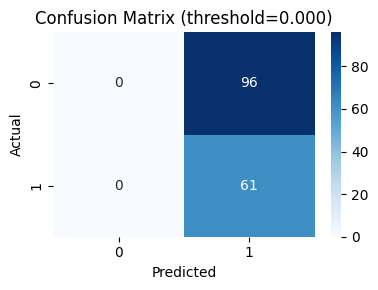

In [28]:
# 3.x.3 Confusion matrix at chosen threshold

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Use CHOSEN_THRESHOLD and true/proba from previous cell
pred = (proba >= CHOSEN_THRESHOLD).astype(int)
cm = confusion_matrix(true, pred)

plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix (threshold={:.3f})'.format(CHOSEN_THRESHOLD))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.show()

In [29]:
# 3.x.4 Schema check and model persistence

import os, json
from sklearn import __version__ as sklearn_version
try:
    import xgboost as xgb
    xgb_version = xgb.__version__
except Exception:
    xgb_version = None
from joblib import dump

# Schema checks for selected features
required_features = ['dmin', 'Year', 'cdi', 'dmin:Year', 'gap', 'sig', 'magnitude', 'depth']
missing = [f for f in required_features if f not in X_train_imputed_selected.columns]
assert not missing, f"Missing required features: {missing}"

# Persist model artifact and threshold
os.makedirs('models', exist_ok=True)
MODEL_PATH = 'models/rf_imputed_selected.pkl'
THRESHOLD_PATH = 'models/threshold.txt'
META_PATH = 'models/model_meta.json'

# Save the RF trained on selected imputed features
# Assumes variable name model_imputed_selected
try:
    dump(model_imputed_selected, MODEL_PATH)
    with open(THRESHOLD_PATH, 'w') as f:
        f.write(str(CHOSEN_THRESHOLD))
    meta = {
        'features': required_features,
        'threshold': CHOSEN_THRESHOLD,
        'sklearn_version': sklearn_version,
        'xgboost_version': xgb_version,
        'random_state': 42,
        'model': 'RandomForestClassifier',
        'notes': 'Recall-first threshold tuned via precision–recall sweep.'
    }
    with open(META_PATH, 'w') as f:
        json.dump(meta, f, indent=2)
    print(f"Saved model -> {MODEL_PATH}\nSaved threshold -> {THRESHOLD_PATH}\nSaved meta -> {META_PATH}")
except NameError:
    print("model_imputed_selected not found. Run training cells first.")

Saved model -> models/rf_imputed_selected.pkl
Saved threshold -> models/threshold.txt
Saved meta -> models/model_meta.json
